In [19]:
import numpy as np
import pickle
import matplotlib as mpl
mpl.use('TkAgg')
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
csfont = {'fontname':'DejaVu Serif'}
ticklabelsize = 6
plt.rcParams['xtick.labelsize'] = ticklabelsize
plt.rcParams['ytick.labelsize'] = ticklabelsize
%matplotlib inline
import sys, os
from azav_util import plot_azav
from common import get_widest_range_file, strip_dirname, get_dict, rms
from derivs import drad, dth
from get_parameter import get_parameter

In [2]:
# Make function to flip array with AZ array with either even or odd symmetry
def symmetrize_field(field, sym):
    nt, nr = np.shape(field)
    new_field = np.copy(field)
    # "Fold" the field in half
       
    # Field is ordered from theta=pi (south pole) to theta=0 (north pole)
    # Average the Northern and Southern hemispheres together (must flip 
    # the Southern hemisphere with respect to latitude, then add or subtract it
    if sym=='even':
        new_field = 0.5*(new_field + np.flip(new_field, axis=0))
    elif sym=='odd':
        new_field = 0.5*(new_field - np.flip(new_field, axis=0))
  
    return new_field

In [4]:
# Get Rachel's solar data
di = get_dict('/mizar/loma3853/fixedflux/paperplots/gongdata/avgong.pkl')
Om = di['om']*1e-9*(2*np.pi) # nHz --> rad/s
rsun = 6.957e10
rr = di['rr']*rsun
tt = di['tt']
cost_2d = di['cost_2d']
sint_2d = di['sint_2d']
rr_2d = di['rr_2d']*rsun
cost = np.cos(tt)
sint = np.sin(tt)

In [5]:
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10, 4.12993261e+10, 3.88242342e+10,
       3.62477788e+10, 3.35640465e+10, 3.07658715e+10, 2.78460882e+10,
       2.48004527e+10, 2.16318175e+10, 1.83538183e+10, 1.50028401e+10,
       1.16941604e+10, 8.69896323e+09, 6.25519871e+09, 4.31282518e+09,
       2.70508335e+09, 1.29888581e+09, 0.00000000e+00])

In [6]:
# Let's remove the r-values lower than 4.176 x 10^10 cm
ircut = np.argmin(np.abs(rr - 4.176e10))
rr = rr[:ircut]
cost_2d = cost_2d[:, :ircut]
sint_2d = sint_2d[:, :ircut]
rr_2d = rr_2d[:, :ircut]
Om = Om[:, :ircut]
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10])

In [7]:
# And the r-values over 6.93e10 (note that at 6.94e10, my quartic CZ-RZ reference state gives nans...)
ircut = np.argmin(np.abs(rr - 6.93e10))
rr = rr[ircut+1:]
cost_2d = cost_2d[:, ircut+1:]
sint_2d = sint_2d[:, ircut+1:]
rr_2d = rr_2d[:, ircut+1:]
Om = Om[:, ircut+1:]
nr = len(rr)
rr

array([6.92087926e+10, 6.90872538e+10, 6.89275210e+10, 6.87120628e+10,
       6.84282867e+10, 6.80789062e+10, 6.76584251e+10, 6.71572428e+10,
       6.65714634e+10, 6.58996955e+10, 6.51402694e+10, 6.42911675e+10,
       6.33503029e+10, 6.23150317e+10, 6.11827799e+10, 5.99502082e+10,
       5.86137686e+10, 5.71694258e+10, 5.56124492e+10, 5.39370644e+10,
       5.21369407e+10, 5.02045644e+10, 4.81366657e+10, 4.59567593e+10,
       4.36766721e+10])

In [8]:
L = (rr_2d*sint_2d)**2.0*Om

In [18]:
# Let's extend these arrays to the Southern hemisphere (keeping them even about the equator)
tt2 = np.zeros(2*nt)
tt2[:nt] = np.pi - tt[::-1]
tt2[nt:] = np.copy(tt)

cost2 = np.cos(tt2)
sint2 = np.sin(tt2)

L2 = np.zeros((2*nt, nr))
L2[:nt, :] = np.copy(L[::-1, :])
L2[nt:, :] = np.copy(L)


NameError: name 'nt' is not defined

ValueError: operands could not be broadcast together with shapes (25,25) (24,25) 

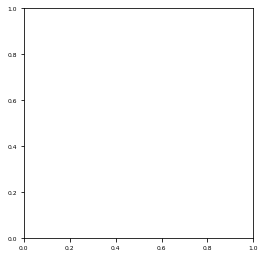

In [17]:
# Make figure
fig_width_inches = 3 + 7/16
margin_inches = 1./8.
margin_top_inches = 1./4.
margin_left_inches = 1./8.
subplot_width_inches = (fig_width_inches - 1*margin_inches - margin_left_inches)
subplot_height_inches = subplot_width_inches
fig_height_inches = 1*(subplot_height_inches + margin_inches) + margin_top_inches

fig_aspect = fig_height_inches/fig_width_inches
margin_x = margin_inches/fig_width_inches
margin_y = margin_inches/fig_height_inches
margin_top = margin_top_inches/fig_height_inches
margin_left = margin_left_inches/fig_width_inches

subplot_width = subplot_width_inches/fig_width_inches
subplot_height = subplot_height_inches/fig_height_inches
   
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

ax1 = fig.add_axes((margin_left, 1 - margin_top - subplot_height, subplot_width, subplot_height))   


units = r'$\rm{Mm^2\ s^{-1}}$'

az_fs = 12
# Ignore NSSL
#ircut = np.argmin(np.abs(rr - 6.7e10))
ircut = 0
cost2=cost_2d
sint2=sint_2d
plot_azav_half (fig, ax1, (L/1e16)[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units=units, odd=False)


fs=14

title = 'solar specific amom'
#title = r'$\langle T\rangle - \langle T\rangle_{\rm{sph}}$'
fig.text(margin_left + 0.5*subplot_width + 0*(subplot_width + margin_x), 1 - margin_top + margin_y/2,\
         title, fontsize=fs, **csfont, ha='center', va='bottom')

#plt.savefig('images/thermo_merplane_Sun_justT.png', dpi=300)